<a href="https://colab.research.google.com/github/szhang12345/MSDS-422-Assignment-8-Language-Modeling-with-an-RNN./blob/main/Assignment_8_Language_Modeling_with_an_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### **MSDS 422 Assignment 8: Language Modeling with an RNN**

**By Siying Zhang**

**Topic: Review**


# Ingest

In [32]:
!pip install chakin

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# Python chakin package previously installed by 
#    pip install chakin
import chakin  

import json
import os
from collections import defaultdict
import nltk 
nltk.download('stopwords')

import datetime

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
import pandas as pd

In [33]:
chakin.search(lang='English')  # lists available indices in English

# Specify English embeddings file to download and install
# by index number, number of dimensions, and subfoder name
# Note that GloVe 50-, 100-, 200-, and 300-dimensional folders
# are downloaded with a single zip download

CHAKIN_INDEX = 18
NUMBER_OF_DIMENSIONS = 50
SUBFOLDER_NAME = "glove.twitter.27B"

DATA_FOLDER = "embeddings"
ZIP_FILE = os.path.join(DATA_FOLDER, "{}.zip".format(SUBFOLDER_NAME))
ZIP_FILE_ALT = "glove" + ZIP_FILE[5:]  # sometimes it's lowercase only...
UNZIP_FOLDER = os.path.join(DATA_FOLDER, SUBFOLDER_NAME)
if SUBFOLDER_NAME[-1] == "d":
    GLOVE_FILENAME = os.path.join(
        UNZIP_FOLDER, "{}.txt".format(SUBFOLDER_NAME))
else:
    GLOVE_FILENAME = os.path.join(UNZIP_FOLDER, "{}.{}d.txt".format(
        SUBFOLDER_NAME, NUMBER_OF_DIMENSIONS))
    
if not os.path.exists(ZIP_FILE) and not os.path.exists(UNZIP_FOLDER):
    print("Downloading embeddings to '{}'".format(ZIP_FILE))
    chakin.download(number=CHAKIN_INDEX, save_dir='./{}'.format(DATA_FOLDER))
else:
    print("Embeddings already downloaded.")

if not os.path.exists(UNZIP_FOLDER):
    import zipfile
    if not os.path.exists(ZIP_FILE) and os.path.exists(ZIP_FILE_ALT):
        ZIP_FILE = ZIP_FILE_ALT
    with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
        print("Extracting embeddings to '{}'".format(UNZIP_FOLDER))
        zip_ref.extractall(UNZIP_FOLDER)
else:
    print("Embeddings already extracted.")

print('\nRun complete')

# Do the same for a different vector/dimension

CHAKIN_INDEX = 11
NUMBER_OF_DIMENSIONS = 50
SUBFOLDER_NAME = "glove.6B"

DATA_FOLDER = "embeddings"
ZIP_FILE = os.path.join(DATA_FOLDER, "{}.zip".format(SUBFOLDER_NAME))
ZIP_FILE_ALT = "glove" + ZIP_FILE[5:]  # sometimes it's lowercase only...
UNZIP_FOLDER = os.path.join(DATA_FOLDER, SUBFOLDER_NAME)
if SUBFOLDER_NAME[-1] == "d":
    GLOVE_FILENAME = os.path.join(
        UNZIP_FOLDER, "{}.txt".format(SUBFOLDER_NAME))
else:
    GLOVE_FILENAME = os.path.join(UNZIP_FOLDER, "{}.{}d.txt".format(
        SUBFOLDER_NAME, NUMBER_OF_DIMENSIONS))
    
if not os.path.exists(ZIP_FILE) and not os.path.exists(UNZIP_FOLDER):
    print("Downloading embeddings to '{}'".format(ZIP_FILE))
    chakin.download(number=CHAKIN_INDEX, save_dir='./{}'.format(DATA_FOLDER))
else:
    print("Embeddings already downloaded.")

if not os.path.exists(UNZIP_FOLDER):
    import zipfile
    if not os.path.exists(ZIP_FILE) and os.path.exists(ZIP_FILE_ALT):
        ZIP_FILE = ZIP_FILE_ALT
    with zipfile.ZipFile(ZIP_FILE, "r") as zip_ref:
        print("Extracting embeddings to '{}'".format(UNZIP_FOLDER))
        zip_ref.extractall(UNZIP_FOLDER)
else:
    print("Embeddings already extracted.")

print('\nRun complete')


                   Name  Dimension  ... Language    Author
2          fastText(en)        300  ...  English  Facebook
11         GloVe.6B.50d         50  ...  English  Stanford
12        GloVe.6B.100d        100  ...  English  Stanford
13        GloVe.6B.200d        200  ...  English  Stanford
14        GloVe.6B.300d        300  ...  English  Stanford
15       GloVe.42B.300d        300  ...  English  Stanford
16      GloVe.840B.300d        300  ...  English  Stanford
17    GloVe.Twitter.25d         25  ...  English  Stanford
18    GloVe.Twitter.50d         50  ...  English  Stanford
19   GloVe.Twitter.100d        100  ...  English  Stanford
20   GloVe.Twitter.200d        200  ...  English  Stanford
21  word2vec.GoogleNews        300  ...  English    Google

[12 rows x 7 columns]
Embeddings already downloaded.
Embeddings already extracted.

Run complete
Embeddings already downloaded.
Embeddings already extracted.

Run complete


In [34]:
!ls -l embeddings

total 2326768
drwxr-xr-x 2 root root       4096 Feb 28 19:36 glove.6B
-rw-r--r-- 1 root root  862182613 Feb 28 19:36 glove.6B.zip
drwxr-xr-x 2 root root       4096 Feb 28 19:29 glove.twitter.27B
-rw-r--r-- 1 root root 1520408563 Feb 28 19:28 glove.twitter.27B.zip


Reading Data

In [35]:
!pip install -U -q PyDrive

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/8_NWU_MSDS422_RNN/assignment8_files/

total 35
drwx------ 3 root root  4096 Feb 28 21:48 embeddings
drwx------ 2 root root  4096 Feb 28 21:33 movie-reviews-negative
drwx------ 2 root root  4096 Feb 28 21:42 movie-reviews-positive
-rw------- 1 root root  2442 Feb 28 21:48 run-chakin-to-get-embeddings-v001.py
-rw------- 1 root root 20021 Feb 28 21:48 run-jump-start-rnn-sentiment-v002.py


In [83]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import re  # regular expressions
from collections import defaultdict
import nltk
from nltk.tokenize import TreebankWordTokenizer

RANDOM_SEED = 42

In [84]:
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

REMOVE_STOPWORDS = False # no stopword removal 
EVOCABSIZE = 1193515  # specify desired size of pre-defined embedding vocabulary

embeddings_directory = 'embeddings/glove.twitter.27B'
filename = 'glove.twitter.27B.100d.txt'

embeddings_filename = os.path.join(embeddings_directory, filename)
embeddings_filename

'embeddings/glove.twitter.27B/glove.twitter.27B.100d.txt'

In [85]:
def load_embedding_from_disks(embeddings_filename, with_indexes=True):
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
  
    else:
        word_to_embedding_dict = dict()

    with open(embeddings_filename, 'r') as embeddings_file:
        for (i, line) in enumerate(embeddings_file):

            split = line.split(' ')

            word = split[0]

            representation = split[1:]
            representation = np.array(
                [float(val) for val in representation]
            )

            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    # Empty representation for unknown words.
    _WORD_NOT_FOUND = [0.0] * len(representation)
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(
            lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(
            index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict

print('\nLoading embeddings from', embeddings_filename)
word_to_index, index_to_embedding = \
    load_embedding_from_disks(embeddings_filename, with_indexes=True)
print("Embedding loaded from disks.")


Loading embeddings from embeddings/glove.twitter.27B/glove.twitter.27B.100d.txt
Embedding loaded from disks.


# EDA

In [86]:
vocab_size, embedding_dim = index_to_embedding.shape
print("Embedding is of shape: {}".format(index_to_embedding.shape))
print("This means (number of words, number of dimensions per word)\n")
print("The first words are words that tend occur more often.")

print("Note: for unknown words, the representation is an empty vector,\n"
      "and the index is the last one. The dictionnary has a limit:")
print("    {} --> {} --> {}".format("A word", "Index in embedding", 
      "Representation"))
word = "worsdfkljsdf"  # a word obviously not in the vocabulary
idx = word_to_index[word] # index for word obviously not in the vocabulary
complete_vocabulary_size = idx 
embd = list(np.array(index_to_embedding[idx], dtype=int)) # "int" compact print
#print("    {} --> {} --> {}".format(word, idx, embd))
word = "the"
idx = word_to_index[word]
embd = list(index_to_embedding[idx])  # "int" for compact print only.
#print("    {} --> {} --> {}".format(word, idx, embd))

Embedding is of shape: (1193515, 100)
This means (number of words, number of dimensions per word)

The first words are words that tend occur more often.
Note: for unknown words, the representation is an empty vector,
and the index is the last one. The dictionnary has a limit:
    A word --> Index in embedding --> Representation


In [87]:
# Show how to use embeddings dictionaries with a test sentence
# This is a famous typing exercise with all letters of the alphabet
# https://en.wikipedia.org/wiki/The_quick_brown_fox_jumps_over_the_lazy_dog
a_typing_test_sentence = 'The quick brown fox jumps over the lazy dog'
print('\nTest sentence: ', a_typing_test_sentence, '\n')
words_in_test_sentence = a_typing_test_sentence.split()

print('Test sentence embeddings from complete vocabulary of', 
      complete_vocabulary_size, 'words:\n')
for word in words_in_test_sentence:
    word_ = word.lower()
    embedding = index_to_embedding[word_to_index[word_]]
    print(word_ + ": ", embedding)


Test sentence:  The quick brown fox jumps over the lazy dog 

Test sentence embeddings from complete vocabulary of 1193514 words:

the:  [ 9.5152e-02  3.7024e-01  5.4291e-01  1.9621e-01  4.8205e-02  3.2033e-01
 -5.9638e-01  1.5868e-02 -1.2989e-01 -6.3028e-01  8.1944e-02  2.4164e-01
 -6.0990e+00 -6.8557e-01  5.0354e-01 -3.4089e-02  1.1705e-01 -7.7403e-03
 -8.6512e-02  4.3617e-01 -4.3982e-01  2.6125e-01 -4.0348e-02 -1.9194e-01
  8.3204e-02 -5.8246e-01 -3.1923e-02  1.2630e-01  4.0120e-01  6.8906e-02
 -1.0517e-01 -2.0804e-01 -4.2554e-01  4.7799e-01  3.4651e-01  2.4057e-01
  5.0244e-02 -7.2587e-02 -2.4347e-03 -5.0342e-01 -1.0601e+00 -3.1586e-01
 -3.2457e-02 -7.6317e-02  7.9045e-01  8.6367e-02 -1.9632e-01  5.7566e-02
  8.4129e-01 -4.2020e-01 -1.1335e-03 -8.5632e-02  6.1910e-02  2.1423e-01
 -1.0356e-01 -3.6946e-02 -2.6005e-01 -3.5657e-01  5.4321e-02  3.0875e-02
  1.4092e-01 -9.1998e-02 -4.1841e-01 -3.1135e-01 -1.4937e-01 -2.2699e-04
 -3.3454e-01 -1.4848e-01 -1.1944e-01 -2.7174e-01  3.1320e-0

In [88]:
# Define vocabulary size for the language model    
# To reduce the size of the vocabulary to the n most frequently used words

def default_factory():
    return EVOCABSIZE  # last/unknown-word row in limited_index_to_embedding
# dictionary has the items() function, returns list of (key, value) tuples
limited_word_to_index = defaultdict(default_factory, \
    {k: v for k, v in word_to_index.items() if v < EVOCABSIZE})

# Select the first EVOCABSIZE rows to the index_to_embedding
limited_index_to_embedding = index_to_embedding[0:EVOCABSIZE,:]
# Set the unknown-word row to be all zeros as previously
limited_index_to_embedding = np.append(limited_index_to_embedding, 
    index_to_embedding[index_to_embedding.shape[0] - 1, :].\
        reshape(1,embedding_dim), 
    axis = 0)

# Delete large numpy array to clear some CPU RAM
del index_to_embedding

# Verify the new vocabulary: should get same embeddings for test sentence
# Note that a small EVOCABSIZE may yield some zero vectors for embeddings
print('\nTest sentence embeddings from vocabulary of', EVOCABSIZE, 'words:\n')
for word in words_in_test_sentence:
    word_ = word.lower()
    embedding = limited_index_to_embedding[limited_word_to_index[word_]]
    print(word_ + ": ", embedding)


Test sentence embeddings from vocabulary of 1193515 words:

the:  [ 9.5152e-02  3.7024e-01  5.4291e-01  1.9621e-01  4.8205e-02  3.2033e-01
 -5.9638e-01  1.5868e-02 -1.2989e-01 -6.3028e-01  8.1944e-02  2.4164e-01
 -6.0990e+00 -6.8557e-01  5.0354e-01 -3.4089e-02  1.1705e-01 -7.7403e-03
 -8.6512e-02  4.3617e-01 -4.3982e-01  2.6125e-01 -4.0348e-02 -1.9194e-01
  8.3204e-02 -5.8246e-01 -3.1923e-02  1.2630e-01  4.0120e-01  6.8906e-02
 -1.0517e-01 -2.0804e-01 -4.2554e-01  4.7799e-01  3.4651e-01  2.4057e-01
  5.0244e-02 -7.2587e-02 -2.4347e-03 -5.0342e-01 -1.0601e+00 -3.1586e-01
 -3.2457e-02 -7.6317e-02  7.9045e-01  8.6367e-02 -1.9632e-01  5.7566e-02
  8.4129e-01 -4.2020e-01 -1.1335e-03 -8.5632e-02  6.1910e-02  2.1423e-01
 -1.0356e-01 -3.6946e-02 -2.6005e-01 -3.5657e-01  5.4321e-02  3.0875e-02
  1.4092e-01 -9.1998e-02 -4.1841e-01 -3.1135e-01 -1.4937e-01 -2.2699e-04
 -3.3454e-01 -1.4848e-01 -1.1944e-01 -2.7174e-01  3.1320e-01 -1.0998e-01
 -4.7524e-01  1.4056e-01  3.9641e-01 -4.9413e-02 -4.2601e

In [89]:
def listdir_no_hidden(path):
    start_list = os.listdir(path)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file)
    return(end_list)

In [90]:
# define list of codes to be dropped from document
# carriage-returns, line-feeds, tabs
codelist = ['\r', '\n', '\t']   

# We will not remove stopwords in this exercise because they are
# important to keeping sentences intact
if REMOVE_STOPWORDS:
    print(nltk.corpus.stopwords.words('english'))

# previous analysis of a list of top terms showed a number of words, along 
# with contractions and other word strings to drop from further analysis, add
# these to the usual English stopwords to be dropped from a document collection
    more_stop_words = ['cant','didnt','doesnt','dont','goes','isnt','hes',\
        'shes','thats','theres','theyre','wont','youll','youre','youve', 'br'\
        've', 're', 'vs'] 

    some_proper_nouns_to_remove = ['dick','ginger','hollywood','jack',\
        'jill','john','karloff','kudrow','orson','peter','tcm','tom',\
        'toni','welles','william','wolheim','nikita']

    # start with the initial list and add to it for movie text work 
    stoplist = nltk.corpus.stopwords.words('english') + more_stop_words +\
        some_proper_nouns_to_remove

In [91]:
# text parsing function for creating text documents 
# there is more we could do for data preparation 
# stemming... looking for contractions... possessives... 
# but we will work with what we have in this parsing function
# if we want to do stemming at a later time, we can use
#     porter = nltk.PorterStemmer()  
# in a construction like this
#     words_stemmed =  [porter.stem(word) for word in initial_words]  
def text_parse(string):
    # replace non-alphanumeric with space 
    temp_string = re.sub('[^a-zA-Z]', '  ', string)    
    # replace codes with space
    for i in range(len(codelist)):
        stopstring = ' ' + codelist[i] + '  '
        temp_string = re.sub(stopstring, '  ', temp_string)      
    # replace single-character words with space
    temp_string = re.sub('\s.\s', ' ', temp_string)   
    # convert uppercase to lowercase
    temp_string = temp_string.lower()    
    if REMOVE_STOPWORDS:
        # replace selected character strings/stop-words with space
        for i in range(len(stoplist)):
            stopstring = ' ' + str(stoplist[i]) + ' '
            temp_string = re.sub(stopstring, ' ', temp_string)        
    # replace multiple blank characters with one blank character
    temp_string = re.sub('\s+', ' ', temp_string)    
    return(temp_string)

def read_data(filename):

  with open(filename) as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = text_parse(data)
    data = TreebankWordTokenizer().tokenize(data)  # The Penn Treebank

  return data

In [92]:
# -----------------------------------------------
# gather data for 500 negative movie reviews
# -----------------------------------------------

dir_name = "/content/drive/My Drive/Colab Notebooks/8_NWU_MSDS422_RNN/assignment8_files/movie-reviews-negative"
#dir_name = '/root/movie-reviews-negative'
    
filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))

# Read data for negative movie reviews
# Data will be stored in a list of lists where the each list represents 
# a document and document is a list of words.
# We then break the text into words.

negative_documents = []

print('\nProcessing document files under', dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    negative_documents.append(words)
    #print('Data size (Characters) (Document %d) %d' %(i,len(words)))
    #print('Sample string (Document %d) %s'%(i,words[:50]))


Directory: /content/drive/My Drive/Colab Notebooks/8_NWU_MSDS422_RNN/assignment8_files/movie-reviews-negative
500 files found

Processing document files under /content/drive/My Drive/Colab Notebooks/8_NWU_MSDS422_RNN/assignment8_files/movie-reviews-negative


In [93]:
# -----------------------------------------------
# gather data for 500 positive movie reviews
# -----------------------------------------------
#dir_name = '/root/movie-reviews-positive'
dir_name = "/content/drive/My Drive/Colab Notebooks/8_NWU_MSDS422_RNN/assignment8_files/movie-reviews-positive"
filenames = listdir_no_hidden(path=dir_name)
num_files = len(filenames)

for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name, filenames[i]))
    assert file_exists
print('\nDirectory:',dir_name)    
print('%d files found' % len(filenames))

# Read data for positive movie reviews
# Data will be stored in a list of lists where the each list 
# represents a document and document is a list of words.
# We then break the text into words.

positive_documents = []

print('\nProcessing document files under', dir_name)
for i in range(num_files):
    ## print(' ', filenames[i])

    words = read_data(os.path.join(dir_name, filenames[i]))

    positive_documents.append(words)
    # print('Data size (Characters) (Document %d) %d' %(i,len(words)))
    # print('Sample string (Document %d) %s'%(i,words[:50]))


Directory: /content/drive/My Drive/Colab Notebooks/8_NWU_MSDS422_RNN/assignment8_files/movie-reviews-positive
500 files found

Processing document files under /content/drive/My Drive/Colab Notebooks/8_NWU_MSDS422_RNN/assignment8_files/movie-reviews-positive


In [94]:
# -----------------------------------------------------
# convert positive/negative documents into numpy array
# note that reviews vary from 22 to 1052 words   
# so we use the first 20 and last 20 words of each review 
# as our word sequences for analysis
# -----------------------------------------------------
max_review_length = 0  # initialize
for doc in negative_documents:
    max_review_length = max(max_review_length, len(doc))    
for doc in positive_documents:
    max_review_length = max(max_review_length, len(doc)) 
print('max_review_length:', max_review_length) 

min_review_length = max_review_length  # initialize
for doc in negative_documents:
    min_review_length = min(min_review_length, len(doc))    
for doc in positive_documents:
    min_review_length = min(min_review_length, len(doc)) 
print('min_review_length:', min_review_length) 

# construct list of 1000 lists with 20 words in each list
from itertools import chain
documents = []
for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    
for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    

# create list of lists of lists for embeddings
embeddings = []    
for doc in documents:
    embedding = []
    for word in doc:
       embedding.append(limited_index_to_embedding[limited_word_to_index[word]]) 
    embeddings.append(embedding)
    
#embeddings

max_review_length: 1052
min_review_length: 22


In [95]:
# -----------------------------------------------------    
# Check on the embeddings list of list of lists 
# -----------------------------------------------------
# Show the first word in the first document
test_word = documents[0][0]    
print('First word in first document:', test_word)    
print('Embedding for this word:\n', 
      limited_index_to_embedding[limited_word_to_index[test_word]])
print('Corresponding embedding from embeddings list of list of lists\n',
      embeddings[0][0][:])

# Show the last word in the last document
test_word = documents[999][39]    
print('First word in first document:', test_word)    
print('Embedding for this word:\n', 
      limited_index_to_embedding[limited_word_to_index[test_word]])
print('Corresponding embedding from embeddings list of list of lists\n',
      embeddings[999][39][:])        

First word in first document: it
Embedding for this word:
 [-4.0204e-02  2.4451e-01  2.7863e-01  3.5576e-01 -6.4794e-02  6.7642e-01
  1.9181e-01 -5.0071e-01  2.7229e-01  6.1884e-01  7.8804e-02  3.6170e-01
 -6.1461e+00 -1.3399e-01  2.5247e-01 -3.9622e-01 -6.2896e-02  6.5510e-02
 -2.6081e-01  1.2262e-01 -1.3021e-01  1.4528e-01 -1.4906e-02  2.0602e-01
  3.8372e-01 -9.1961e-02 -1.6881e-01 -1.1129e-01  5.8092e-01 -1.7041e-01
 -5.1822e-01  4.4937e-01 -1.8692e-01  4.5443e-01 -1.8467e-01  2.4614e-02
 -8.3466e-02 -3.5212e-01  2.5468e-01 -9.8679e-02 -1.1378e+00 -2.4484e-01
  6.7094e-03 -8.4167e-03  5.2478e-01  6.0223e-02 -1.9183e-01  6.0694e-02
 -1.4727e-01  1.8366e-01 -2.0860e-01  2.2762e-01 -1.1646e-01 -3.7232e-01
  4.1695e-01 -2.7496e-03 -1.5487e-01 -2.0468e-01  6.6389e-02  3.5824e-01
  1.3098e-01 -1.2687e-01 -1.2217e-02  3.0690e-01  2.8404e-01 -3.3045e-01
 -5.0693e-01  1.0172e-01 -4.3456e-01 -8.0154e-02  1.3064e-01  3.8311e-01
  1.6287e-01 -3.9300e-01  2.2813e-01  3.5973e-02 -1.1221e-02  1.8

In [96]:
RANDOM_SEED = 9999
# -----------------------------------------------------    
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
# -----------------------------------------------------
embeddings_array = np.array(embeddings)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

# Modeling

Dictionary for result tracking

In [98]:
# Initialize a dictionary to track results
metrics = {}


# Metrics for evaluation
names = ['Epoch Count','Time (s)','Training Accuracy', 'Test Accuracy']


Model Set 1: RNN variations using embedding: Glove.twitter.27B 100d/1.2M words

Model 1a: Jump start model - simple RNN

In [99]:
# --------------------------------------------------------------------------      
# We use a very simple Recurrent Neural Network for this assignment
# Géron, A. 2017. Hands-On Machine Learning with Scikit-Learn & TensorFlow: 
#    Concepts, Tools, and Techniques to Build Intelligent Systems. 
#    Sebastopol, Calif.: O'Reilly. [ISBN-13 978-1-491-96229-9] 
#    Chapter 14 Recurrent Neural Networks, pages 390-391
#    Source code available at https://github.com/ageron/handson-ml 
# --------------------------------------------------------------------------  
reset_graph()

n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.001

# Start timer
start = datetime.datetime.now()

# Set X and y placeholders

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 100
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        print('\n  ---- Epoch ', epoch, ' ----\n')
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            print('  Batch ', iteration, ' training observations from ',  
                  iteration*batch_size, ' to ', (iteration + 1)*batch_size-1,)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print('\n  Train accuracy:', acc_train, 'Test accuracy:', acc_test)
    
# Record the time it takes
duration = datetime.datetime.now() - start

metrics['Model 1a-simple RNN (100d)'] = [100,duration, acc_train, acc_test]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:421: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/p


  ---- Epoch  0  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799

  Train accuracy: 0.54 Test accuracy: 0.53

  ---- Epoch  1  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799

  Train accuracy: 0.57 Test accuracy: 0.565

  ---- Epoch  2  ---

Model 1b: Long Short Term Memory Model (LSTM) 

In [100]:
reset_graph()

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)

n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up
n_layers = 3

learning_rate = 0.0001

# Start timer
start = datetime.datetime.now()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 100
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            print('  Batch ', iteration, ' training observations from ',  
                  iteration*batch_size, ' to ', (iteration + 1)*batch_size-1,)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)


# Record the time it takes
duration = datetime.datetime.now() - start

metrics['Model 1b-LSTM (100d)'] = [100,duration, acc_train, acc_test]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/pyth

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799
Epoch 0 Train accuracy = 0.5 Test accuracy = 0.49
  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799
Epoch 1 Train accuracy = 0.5 Test accuracy = 0.495
  Batch  0  training observations from  0  to  99
  Batch

Model 1c: Drop cell (twitter.100d)


In [101]:
reset_graph()

# lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up
n_layers = 3

learning_rate = 0.001

# Start timer
start = datetime.datetime.now()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

keep_prob = tf.placeholder_with_default(.95, shape=())
cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
        
n_epochs = 100
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

# Record the time it takes
duration = datetime.datetime.now() - start

metrics['Model 1c-Drop Cell (100d)'] = [100,duration, acc_train, acc_test]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:421: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/p

0 Train accuracy: 0.47 Test accuracy: 0.54
1 Train accuracy: 0.5 Test accuracy: 0.54
2 Train accuracy: 0.52 Test accuracy: 0.55
3 Train accuracy: 0.48 Test accuracy: 0.56
4 Train accuracy: 0.64 Test accuracy: 0.54
5 Train accuracy: 0.6 Test accuracy: 0.555
6 Train accuracy: 0.71 Test accuracy: 0.6
7 Train accuracy: 0.7 Test accuracy: 0.61
8 Train accuracy: 0.71 Test accuracy: 0.615
9 Train accuracy: 0.75 Test accuracy: 0.64
10 Train accuracy: 0.78 Test accuracy: 0.65
11 Train accuracy: 0.76 Test accuracy: 0.665
12 Train accuracy: 0.76 Test accuracy: 0.665
13 Train accuracy: 0.73 Test accuracy: 0.64
14 Train accuracy: 0.8 Test accuracy: 0.685
15 Train accuracy: 0.81 Test accuracy: 0.65
16 Train accuracy: 0.84 Test accuracy: 0.68
17 Train accuracy: 0.77 Test accuracy: 0.665
18 Train accuracy: 0.81 Test accuracy: 0.675
19 Train accuracy: 0.82 Test accuracy: 0.65
20 Train accuracy: 0.83 Test accuracy: 0.645
21 Train accuracy: 0.85 Test accuracy: 0.66
22 Train accuracy: 0.88 Test accuracy: 

Model Set 2: RNN variation models using embedding: Glove.6B 300d/400k words

Embedding setup for RNN variation models using embedding: Glove.6B 300d/400k words

In [102]:
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

REMOVE_STOPWORDS = False  # no stopword removal 
EVOCABSIZE = 400000

embeddings_directory = 'embeddings/glove.6B'
filename = 'glove.6B.300d.txt'

embeddings_filename = os.path.join(embeddings_directory, filename)
embeddings_filename

'embeddings/glove.6B/glove.6B.300d.txt'

In [103]:
def load_embedding_from_disks(embeddings_filename, with_indexes=True):
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
  
    else:
        word_to_embedding_dict = dict()

    with open(embeddings_filename, 'r') as embeddings_file:
        for (i, line) in enumerate(embeddings_file):

            split = line.split(' ')

            word = split[0]

            representation = split[1:]
            representation = np.array(
                [float(val) for val in representation]
            )

            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    # Empty representation for unknown words.
    _WORD_NOT_FOUND = [0.0] * len(representation)
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(
            lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(
            index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict

print('\nLoading embeddings from', embeddings_filename)
word_to_index, index_to_embedding = \
    load_embedding_from_disks(embeddings_filename, with_indexes=True)
print("Embedding loaded from disks.")


Loading embeddings from embeddings/glove.6B/glove.6B.300d.txt
Embedding loaded from disks.


In [104]:
vocab_size, embedding_dim = index_to_embedding.shape
print("Embedding is of shape: {}".format(index_to_embedding.shape))
print("This means (number of words, number of dimensions per word)\n")
print("The first words are words that tend occur more often.")

print("Note: for unknown words, the representation is an empty vector,\n"
      "and the index is the last one. The dictionnary has a limit:")
print("    {} --> {} --> {}".format("A word", "Index in embedding", 
      "Representation"))
word = "worsdfkljsdf"  # a word obviously not in the vocabulary
idx = word_to_index[word] # index for word obviously not in the vocabulary
complete_vocabulary_size = idx 
embd = list(np.array(index_to_embedding[idx], dtype=int)) # "int" compact print
#print("    {} --> {} --> {}".format(word, idx, embd))
word = "the"
idx = word_to_index[word]
embd = list(index_to_embedding[idx])  # "int" for compact print only.
#print("    {} --> {} --> {}".format(word, idx, embd))

Embedding is of shape: (400001, 300)
This means (number of words, number of dimensions per word)

The first words are words that tend occur more often.
Note: for unknown words, the representation is an empty vector,
and the index is the last one. The dictionnary has a limit:
    A word --> Index in embedding --> Representation


In [105]:
def default_factory():
    return EVOCABSIZE  # last/unknown-word row in limited_index_to_embedding
# dictionary has the items() function, returns list of (key, value) tuples
limited_word_to_index = defaultdict(default_factory, \
    {k: v for k, v in word_to_index.items() if v < EVOCABSIZE})

# Select the first EVOCABSIZE rows to the index_to_embedding
limited_index_to_embedding = index_to_embedding[0:EVOCABSIZE,:]
# Set the unknown-word row to be all zeros as previously
limited_index_to_embedding = np.append(limited_index_to_embedding, 
    index_to_embedding[index_to_embedding.shape[0] - 1, :].\
        reshape(1,embedding_dim), 
    axis = 0)

# Delete large numpy array to clear some CPU RAM
del index_to_embedding

# Verify the new vocabulary: should get same embeddings for test sentence
# Note that a small EVOCABSIZE may yield some zero vectors for embeddings
print('\nTest sentence embeddings from vocabulary of', EVOCABSIZE, 'words:\n')
for word in words_in_test_sentence:
    word_ = word.lower()
    embedding = limited_index_to_embedding[limited_word_to_index[word_]]
    print(word_ + ": ", embedding)


Test sentence embeddings from vocabulary of 400000 words:

the:  [ 4.6560e-02  2.1318e-01 -7.4364e-03 -4.5854e-01 -3.5639e-02  2.3643e-01
 -2.8836e-01  2.1521e-01 -1.3486e-01 -1.6413e+00 -2.6091e-01  3.2434e-02
  5.6621e-02 -4.3296e-02 -2.1672e-02  2.2476e-01 -7.5129e-02 -6.7018e-02
 -1.4247e-01  3.8825e-02 -1.8951e-01  2.9977e-01  3.9305e-01  1.7887e-01
 -1.7343e-01 -2.1178e-01  2.3617e-01 -6.3681e-02 -4.2318e-01 -1.1661e-01
  9.3754e-02  1.7296e-01 -3.3073e-01  4.9112e-01 -6.8995e-01 -9.2462e-02
  2.4742e-01 -1.7991e-01  9.7908e-02  8.3118e-02  1.5299e-01 -2.7276e-01
 -3.8934e-02  5.4453e-01  5.3737e-01  2.9105e-01 -7.3514e-03  4.7880e-02
 -4.0760e-01 -2.6759e-02  1.7919e-01  1.0977e-02 -1.0963e-01 -2.6395e-01
  7.3990e-02  2.6236e-01 -1.5080e-01  3.4623e-01  2.5758e-01  1.1971e-01
 -3.7135e-02 -7.1593e-02  4.3898e-01 -4.0764e-02  1.6425e-02 -4.4640e-01
  1.7197e-01  4.6246e-02  5.8639e-02  4.1499e-02  5.3948e-01  5.2495e-01
  1.1361e-01 -4.8315e-02 -3.6385e-01  1.8704e-01  9.2761e-

In [106]:
# -----------------------------------------------------
# convert positive/negative documents into numpy array
# note that reviews vary from 22 to 1052 words   
# so we use the first 20 and last 20 words of each review 
# as our word sequences for analysis
# -----------------------------------------------------
max_review_length = 0  # initialize
for doc in negative_documents:
    max_review_length = max(max_review_length, len(doc))    
for doc in positive_documents:
    max_review_length = max(max_review_length, len(doc)) 
print('max_review_length:', max_review_length) 

min_review_length = max_review_length  # initialize
for doc in negative_documents:
    min_review_length = min(min_review_length, len(doc))    
for doc in positive_documents:
    min_review_length = min(min_review_length, len(doc)) 
print('min_review_length:', min_review_length) 

# construct list of 1000 lists with 40 words in each list
from itertools import chain
documents = []
for doc in negative_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    
for doc in positive_documents:
    doc_begin = doc[0:20]
    doc_end = doc[len(doc) - 20: len(doc)]
    documents.append(list(chain(*[doc_begin, doc_end])))    

# create list of lists of lists for embeddings
embeddings = []    
for doc in documents:
    embedding = []
    for word in doc:
       embedding.append(limited_index_to_embedding[limited_word_to_index[word]]) 
    embeddings.append(embedding)
    
# embeddings

max_review_length: 1052
min_review_length: 22


In [107]:
# -----------------------------------------------------    
# Check on the embeddings list of list of lists 
# -----------------------------------------------------
# Show the first word in the first document
test_word = documents[0][0]    
print('First word in first document:', test_word)    
print('Embedding for this word:\n', 
      limited_index_to_embedding[limited_word_to_index[test_word]])
print('Corresponding embedding from embeddings list of list of lists\n',
      embeddings[0][0][:])

# Show the seventh word in the tenth document
test_word = documents[6][9]    
print('First word in first document:', test_word)    
print('Embedding for this word:\n', 
      limited_index_to_embedding[limited_word_to_index[test_word]])
print('Corresponding embedding from embeddings list of list of lists\n',
      embeddings[6][9][:])

# Show the last word in the last document
test_word = documents[999][39]    
print('First word in first document:', test_word)    
print('Embedding for this word:\n', 
      limited_index_to_embedding[limited_word_to_index[test_word]])
print('Corresponding embedding from embeddings list of list of lists\n',
      embeddings[999][39][:])        

First word in first document: it
Embedding for this word:
 [ 3.3284e-02 -4.0754e-02 -4.8377e-02  1.2017e-01 -1.3915e-01 -1.7694e-01
 -6.2908e-02  1.7056e-01  2.0077e-01 -2.4287e+00  4.0703e-01 -9.9281e-02
  7.2288e-02  2.1508e-01  2.4937e-01  2.5853e-01 -6.6372e-01  2.2472e-01
  2.5758e-01 -1.7459e-01  3.5456e-01  7.4112e-01  1.4282e-01  2.6240e-01
 -6.3519e-01 -1.1300e-01 -1.2607e-01 -1.7486e-01 -3.3581e-01  3.0123e-01
  3.0055e-02  5.0420e-01 -4.9208e-01 -1.9790e-02 -8.6798e-01  1.8906e-01
 -1.4333e-01  1.2869e-01 -2.4102e-01 -1.5733e-01  1.4114e-01 -2.3983e-02
 -1.8256e-01  1.9093e-01  3.8730e-01  3.6151e-01  3.9893e-01 -3.3628e-02
 -1.3357e-03  2.7212e-02 -1.5565e-01  4.9335e-02 -6.7375e-03 -1.1839e-01
 -2.5112e-01  7.7261e-02  1.0928e-01  3.1826e-01  3.0289e-01 -1.0824e-01
  1.4565e-01 -1.1714e-02  1.3254e-01  2.5120e-02 -8.5447e-02 -5.8705e-01
  4.5260e-02  1.5113e-01  2.0622e-01 -1.0576e-02  4.1560e-02 -4.3666e-02
  1.2812e-02  5.6017e-01  2.4370e-03 -1.9418e-01  1.5809e-01  2.3

In [108]:
RANDOM_SEED = 9999
# -----------------------------------------------------    
# Make embeddings a numpy array for use in an RNN 
# Create training and test sets with Scikit Learn
# -----------------------------------------------------
embeddings_array = np.array(embeddings)

# Define the labels to be used 500 negative (0) and 500 positive (1)
thumbs_down_up = np.concatenate((np.zeros((500), dtype = np.int32), 
                      np.ones((500), dtype = np.int32)), axis = 0)

# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(embeddings_array, thumbs_down_up, test_size=0.20, 
                     random_state = RANDOM_SEED)

Model 2a: simple RNN (300d)


In [109]:
reset_graph()

n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up

learning_rate = 0.001
# Start timer
start = datetime.datetime.now()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 100
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        print('\n  ---- Epoch ', epoch, ' ----\n')
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            print('  Batch ', iteration, ' training observations from ',  
                  iteration*batch_size, ' to ', (iteration + 1)*batch_size-1,)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print('\n  Train accuracy:', acc_train, 'Test accuracy:', acc_test)
        
# Record the time it takes
duration = datetime.datetime.now() - start
metrics['Model 2a-simple RNN (300d)'] = [100,duration, acc_train, acc_test]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:421: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/p


  ---- Epoch  0  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799

  Train accuracy: 0.56 Test accuracy: 0.49

  ---- Epoch  1  ----

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799

  Train accuracy: 0.63 Test accuracy: 0.555

  ---- Epoch  2  ---

Model 2b: Long Short term Memory (LTSM)

In [110]:

reset_graph()

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)

n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up
n_layers = 3

learning_rate = 0.0001

# Start timer
start = datetime.datetime.now()


X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 100
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):          
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            print('  Batch ', iteration, ' training observations from ',  
                  iteration*batch_size, ' to ', (iteration + 1)*batch_size-1,)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

# Record the time it takes
duration = datetime.datetime.now() - start

metrics['Model 2b-LTSM (300d)'] = [100,duration, acc_train, acc_test]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/pyth

  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799
Epoch 0 Train accuracy = 0.5 Test accuracy = 0.48
  Batch  0  training observations from  0  to  99
  Batch  1  training observations from  100  to  199
  Batch  2  training observations from  200  to  299
  Batch  3  training observations from  300  to  399
  Batch  4  training observations from  400  to  499
  Batch  5  training observations from  500  to  599
  Batch  6  training observations from  600  to  699
  Batch  7  training observations from  700  to  799
Epoch 1 Train accuracy = 0.48 Test accuracy = 0.48
  Batch  0  training observations from  0  to  99
  Batch

Model 2c: Drop cell (300d)

In [111]:
reset_graph()

# lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

n_steps = embeddings_array.shape[1]  # number of words per document 
n_inputs = embeddings_array.shape[2]  # dimension of  pre-trained embeddings
n_neurons = 20  # analyst specified number of neurons
n_outputs = 2  # thumbs-down or thumbs-up
n_layers = 3

learning_rate = 0.001
# Start timer
start = datetime.datetime.now()

# Set X and y placeholders

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

keep_prob = tf.placeholder_with_default(.5, shape=())
cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
        
n_epochs = 100
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

# Record the time it takes
duration = datetime.datetime.now() - start

metrics['Model 2c-Drop Cell (300d)'] = [100,duration, acc_train, acc_test]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:421: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/p

0 Train accuracy: 0.5 Test accuracy: 0.485
1 Train accuracy: 0.48 Test accuracy: 0.49
2 Train accuracy: 0.55 Test accuracy: 0.455
3 Train accuracy: 0.6 Test accuracy: 0.54
4 Train accuracy: 0.5 Test accuracy: 0.5
5 Train accuracy: 0.62 Test accuracy: 0.525
6 Train accuracy: 0.55 Test accuracy: 0.49
7 Train accuracy: 0.55 Test accuracy: 0.545
8 Train accuracy: 0.62 Test accuracy: 0.58
9 Train accuracy: 0.66 Test accuracy: 0.525
10 Train accuracy: 0.69 Test accuracy: 0.535
11 Train accuracy: 0.62 Test accuracy: 0.61
12 Train accuracy: 0.61 Test accuracy: 0.515
13 Train accuracy: 0.63 Test accuracy: 0.545
14 Train accuracy: 0.7 Test accuracy: 0.57
15 Train accuracy: 0.66 Test accuracy: 0.565
16 Train accuracy: 0.73 Test accuracy: 0.605
17 Train accuracy: 0.65 Test accuracy: 0.57
18 Train accuracy: 0.78 Test accuracy: 0.59
19 Train accuracy: 0.71 Test accuracy: 0.595
20 Train accuracy: 0.72 Test accuracy: 0.585
21 Train accuracy: 0.76 Test accuracy: 0.605
22 Train accuracy: 0.7 Test accura

Result

In [112]:
# Convert metrics dictionary to dataframe for display
results = pd.DataFrame.from_dict(metrics, orient='index')
results.columns = names

# Sort by model number
results.reset_index(inplace=True)
results.sort_values(by=['index'], axis=0, inplace=True)
results.set_index(['index'], inplace=True)
results.index.name = None
results


,Epoch Count,Time (s),Training Accuracy,Test Accuracy
Model 1a-simple RNN (100d),100,0 days 00:00:12.424161,0.99,0.685
Model 1b-LSTM (100d),100,0 days 00:00:35.369073,0.93,0.665
Model 1c-Drop Cell (100d),100,0 days 00:00:22.474514,0.97,0.640
Model 2a-simple RNN (300d),100,0 days 00:00:23.215711,1.00,0.660
Model 2b-LTSM (300d),100,0 days 00:00:47.749650,0.95,0.695
Model 2c-Drop Cell (300d),100,0 days 00:00:41.109933,0.86,0.655


# Conclusion

# Background and management problem description

Establishing an effective and efficient customer management system by building a language model that is capable of identifying negative customer feelings

# Research design and modeling methods
Utilize RNN within Python for negative and positive comments identification.
The steps for the analysis are the following:
1.	Revise the jump-start code to accommodate two pre-trained word vectors and two vocabulary sizes. 
2.	Build four distinct language models by twisting the RNN structures or hyperparameter settings.
3.	Evaluate four language models using classification accuracy in the test set. 

# Results and Recommendations
Below is a summary of the models that were created in the process of this analysis and their performance comparison. Performance variables include processing time and the accuracy scores of training and test sets.

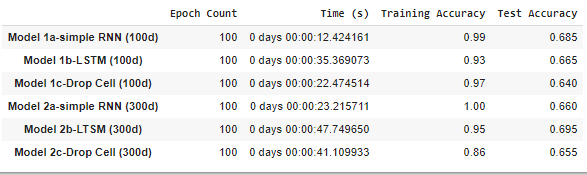

With a 69.5% Test accuracy and 95% Training accuracy, if not considering the process time, I would recommend Model 2b-LTSM (300d) to be used as an language model for building a customer support system that is capable to identify negative comments from customers, if taking into consideration of process time, Model 1a-simple RNN (100d) can be used as an alternative option for speedy identification, with a slightly lower test accuracy of 68.5%.